# Example notebook

## I. Preparation

### 1. Import dependencies and setup environment

Import a few Python libraries that we need for our data analysis. We also need to tell MINER where the input data resides and where the results should go. We assume that the reference data was downloaded from (https://networks.systemsbiology.net/downloads/miner-examples/miner_mindata.tar.gz) and resides in the directory `miner_mindata`.

MINER requires an expression matrix, and if available an identifier mapping file. See the `identifier_mappings.txt` file for an example of the structure of the mapping file. The `preprocess()` function prepares the input file into a pandas data frame that can be used for the subsequent steps.

In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from miner import miner
%matplotlib inline
plt.style.use('ggplot')

DATA_DIR = "miner_mindata"
OUTPUT_DIR = "miner_example_out"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Load expression Data
expression_path = os.path.join(DATA_DIR, "expression", "IA12Zscore.csv")
idmap_path = os.path.join(DATA_DIR, "identifier_mappings.txt")
exp_data, conv_table = miner.preprocess(expression_path, idmap_path)

completed identifier conversion.
16216 genes were converted.


### 2. Visualizing the pre-processed expression data

It can be helpful to see a visual representation of the structure of the input data. The section below helps with that.

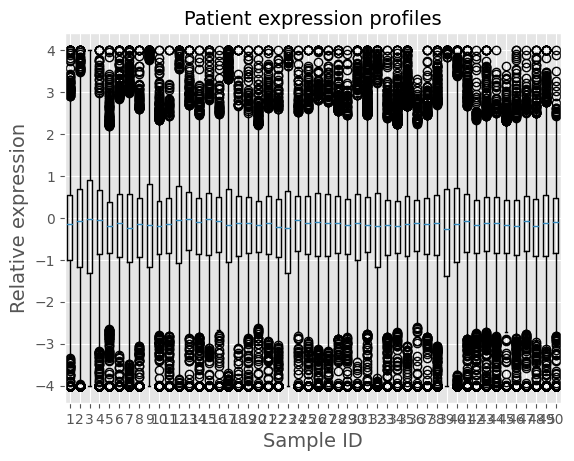

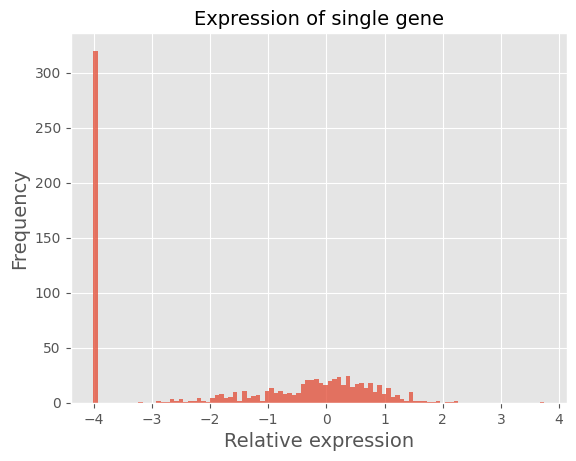

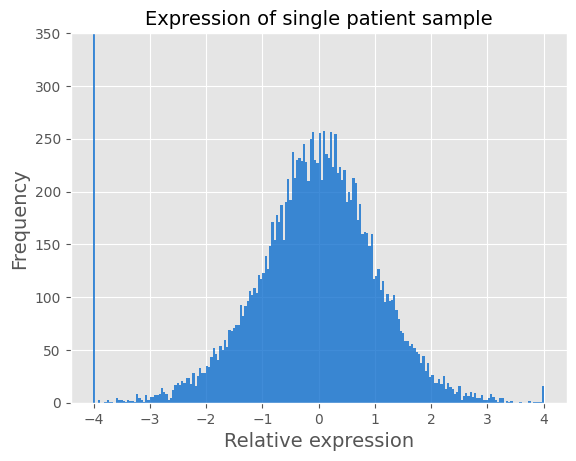

In [2]:
individual_exp_data = [exp_data.iloc[:,i] for i in range(50)]
plt.boxplot(individual_exp_data)
plt.title("Patient expression profiles", fontsize=14)
plt.ylabel("Relative expression", fontsize=14)
plt.xlabel("Sample ID", fontsize=14)
plt.figure()

plt.hist(exp_data.iloc[0,:], bins=100, alpha=0.75)
plt.title("Expression of single gene", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Relative expression", fontsize=14)
plt.figure()

plt.hist(exp_data.iloc[:,0], bins=200, color=[0,0.4,0.8], alpha=0.75)
plt.ylim(0, 350)
plt.title("Expression of single patient sample", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
_ = plt.xlabel("Relative expression", fontsize=14)

## I. Co-expression Clustering

### 1. Setting up parameters

In [3]:
# minimum number of genes that form an acceptable coexpression cluster:
MIN_NUMBER_GENES = 6 # bulk RNAseq default=6; single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
MIN_CORRELATION = 0.2 # bulk RNAseq default=0.2; single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
MIN_NUMBER_REGULON_GENES = 5 # bulk RNAseq default=5; single cell RNAseq default=4

# choose TF database
TFDB_PATH = os.path.join(DATA_DIR, "network_dictionaries", "tfbsdb_tf_to_genes.pkl")

# number of cores to use for parallel computation. Some functions run very slowly
# without parallel computation
NUM_CORES = 5

### 2. Run clustering and write results

In [4]:
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initial_clusters = miner.cluster(exp_data,
                                 minNumberGenes=MIN_NUMBER_GENES,
                                 minNumberOverExpSamples=4,
                                 maxSamplesExcluded=0.50,
                                 random_state=17,
                                 overExpressionThreshold=80)

# revise initial_clusters to combine highly correlated clusters and keep only those with significant coexpression
revised_clusters = miner.reviseInitialClusters(initial_clusters, exp_data)

# write revised_clusters to .json file
miner.write_json(revised_clusters, os.path.join(OUTPUT_DIR, "coexpressionDictionary.json"))

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 1.86 minutes


### 3. Visualize the first n clusters (n=3)

In [5]:
FIRST_N = 3

first_n_clusters = np.hstack([revised_clusters[i] for i in np.arange(FIRST_N).astype(str)])

#### Background Expression

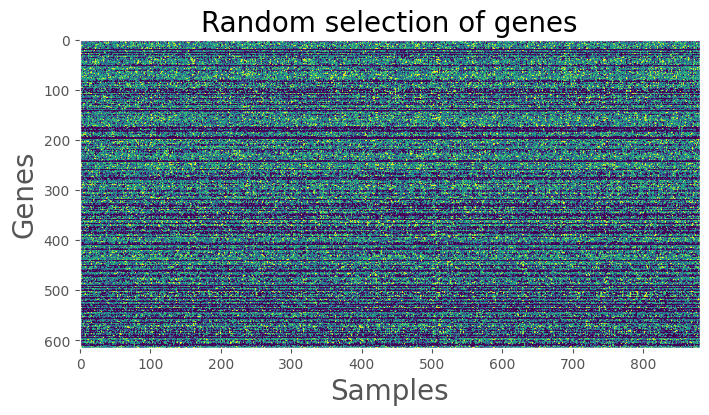

In [6]:
plt.figure(figsize=(8,4))
plt.imshow(exp_data.loc[np.random.choice(exp_data.index,len(first_n_clusters),
                                         replace=False),:],
           aspect="auto",
           cmap="viridis",
           vmin=-1,
           vmax=1)
plt.grid(False)
plt.ylabel("Genes", fontsize=20)
plt.xlabel("Samples", fontsize=20)
_ = plt.title("Random selection of genes", fontsize=20)

### Expression of the first n clusters

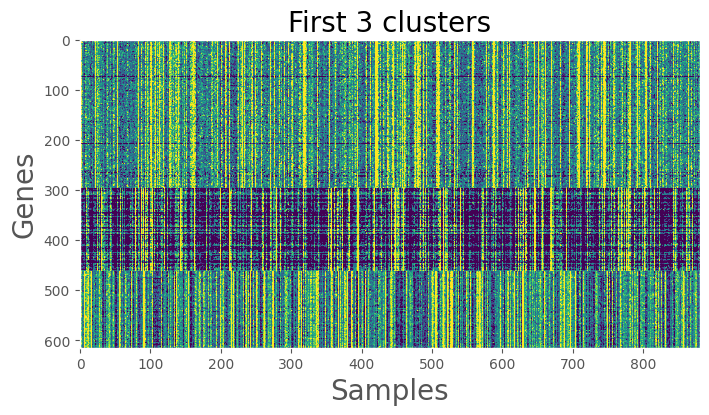

In [7]:
plt.figure(figsize=(8, 4))
plt.imshow(exp_data.loc[first_n_clusters,:], aspect="auto", cmap="viridis", vmin=-1, vmax=1)
plt.grid(False)
plt.ylabel("Genes", fontsize=20)
plt.xlabel("Samples", fontsize=20)
_= plt.title("First %d clusters" % FIRST_N, fontsize=20)

## II. Compute the Mechanistic Inference

In [8]:
# get first principal component axes of clusters
axes = miner.principalDf(revised_clusters, exp_data, subkey=None, minNumberGenes=1)

# analyze revised clusters for enrichment in relational database
# (default: transcription factor binding site database)
mechanistic_output = miner.mechanisticInference(axes, revised_clusters, exp_data,
                                                correlationThreshold=MIN_CORRELATION,
                                                numCores=NUM_CORES,
                                                database_path=TFDB_PATH)

# order mechanisticOutput as dictionary of the form {tf: {coexpressionModule: genes } }
coregulation_modules = miner.getCoregulationModules(mechanistic_output)

# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulation_modules,
                             minNumberGenes=MIN_NUMBER_REGULON_GENES,
                             freqThreshold=0.333)

# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulon_modules, regulon_df = miner.regulonDictionary(regulons)

# define coexpression modules as composite of coexpressed regulons
coexpression_modules = miner.getCoexpressionModules(mechanistic_output)

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(regulon_modules, exp_data, regulon_dict=None, saveFolder=None)
eigen_scale = np.percentile(exp_data, 95) / np.percentile(eigengenes, 95)
eigengenes = eigen_scale * eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)

# Write results to output directory
# write results to JSON files
miner.write_json(mechanistic_output, os.path.join(OUTPUT_DIR, "mechanisticOutput.json"))
miner.write_json(coregulation_modules, os.path.join(OUTPUT_DIR, "coregulationModules.json"))
miner.write_json(regulon_modules, os.path.join(OUTPUT_DIR, "regulons.json"))
miner.write_json(coexpression_modules, os.path.join(OUTPUT_DIR, "coexpressionModules.json"))

# write regulonDf to csv using preferred gene name identifiers
regulon_df.to_csv(os.path.join(OUTPUT_DIR, "regulonDf.csv"))

# write eigengenes to .csv
eigengenes.to_csv(os.path.join(OUTPUT_DIR,"eigengenes.csv"))

Running mechanistic inference
READING TFBS2GENES:  miner_mindata/network_dictionaries/tfbsdb_tf_to_genes.pkl


## III. Compute Causal Inference

We have a set of three different mutation matrices. In this case, we perform causal network analysis on each of them individually and collect the results into a single result file

In [ ]:
# Load mutation matrices
common_mutations = pd.read_csv(os.path.join(DATA_DIR, "mutations", "commonMutations.csv"),
                               index_col=0, header=0)

translocations = pd.read_csv(os.path.join(DATA_DIR, "mutations", "translocationsIA12.csv"),
                             index_col=0, header=0)

cytogenetics = pd.read_csv(os.path.join(DATA_DIR, "mutations", "cytogenetics.csv"),
                           index_col=0, header=0)

# and perform causal analysis for each mutation matrix
reference_dictionary = regulon_modules
reference_regulon_df = regulon_df
reference_df = eigengenes
mut_matrices = [
    (common_mutations, "common_mutations"),
    (translocations, "translocations"),
    (cytogenetics, "cytogenetics") 
]
causal_directory = os.path.join(OUTPUT_DIR, "causal_analysis")

for mut_matrix, mut_name in mut_matrices:
    miner.causalNetworkAnalysis(regulon_matrix=reference_regulon_df.copy(),
                                expression_matrix=exp_data.copy(),
                                reference_matrix=reference_df.copy(),
                                mutation_matrix=mut_matrix.copy(),
                                resultsDirectory=causal_directory,
                                minRegulons=1,
                                significance_threshold=0.05,
                                causalFolder="causal_results_" + mut_name)

# compile all causal results
causal_results = miner.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(OUTPUT_DIR, "completeCausalResults.csv"))

# preview of the causal results
causal_results.head()

Creating directories if dont exist
Testing correlation of TF and cluster eigengene.
Looping through each mutation
